In [1]:
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import os

from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D,MaxPooling2D,Flatten,Conv1D,Softmax
from keras.preprocessing import sequence

from sklearn.model_selection import train_test_split


import json
import numpy as np
import pandas as pd
from sklearn import preprocessing
import keras
from keras.layers import Input,Dense,Lambda,RepeatVector,Dot
from keras.models import Model
import os
import numpy as np
from keras.preprocessing import image as image_p
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.vgg16 import VGG16
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import pickle
import matplotlib.image as mpimg
from keras.preprocessing import image
from  matplotlib import pyplot
from keras.layers.normalization import BatchNormalization
import cv2
import seaborn as sns
import random
from PIL import Image
from sklearn.utils import class_weight
from keras.layers import Reshape,merge,Concatenate,Add
import keras.backend as K
import math
from keras.activations import softmax,tanh
import tensorflow as tf
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4750402895016474652, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 24125253223
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17881239500058392913
 physical_device_desc: "device: 0, name: Quadro P6000, pci bus id: 0000:00:05.0, compute capability: 6.1"]

In [3]:
def wing_loss(landmarks, labels, w=10.0, epsilon=2.0):
    """
    Arguments:
        landmarks, labels: float tensors with shape [batch_size, num_landmarks, 2].
        w, epsilon: a float numbers.
    Returns:
        a float tensor with shape [].
    """
    with tf.name_scope('wing_loss'):
        x = landmarks - labels
        c = w * (1.0 - math.log(1.0 + w/epsilon))
        absolute_x = tf.abs(x)
        losses = tf.where(
            tf.greater(w, absolute_x),
            w * tf.log(1.0 + absolute_x/epsilon),
            absolute_x - c
        )
        loss = tf.reduce_mean(tf.reduce_sum(losses, axis=[1]), axis=0)
        return loss

In [4]:
def attention_block(x,K,labels,w,h):
    H = Conv2D(K, kernel_size=(w, h), padding="same")(x)
    H = BatchNormalization()(H)
    spatial_softmax = Lambda(lambda x:softmax(H,axis=3))(H)
    O = Conv2D(labels*K, kernel_size=(w, h), padding="same")(x)
    O = BatchNormalization()(O)
    rH = Lambda(lambda x:keras.backend.repeat_elements(x, rep=labels, axis=3))(spatial_softmax)
    o = Lambda(lambda x: tf.einsum('bijk,bijk->bk',x[0],x[1]))([O,rH])
    tempH = Conv2D(K, kernel_size=(w, h), padding="same")(x)
    tempH = BatchNormalization()(tempH)
    gh = Lambda(lambda x: softmax(tanh(tf.einsum('bijk,bijk->bk',x[0],x[1])),axis=1))([tempH,spatial_softmax])
    rgh = Lambda(lambda x:keras.backend.repeat_elements(x, rep=labels, axis=1))(gh)
    of = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([rgh,o])
    new_shape = Reshape((labels,K))(of)
    out = Lambda(lambda x: keras.backend.sum(x,axis=2))(new_shape)
    #x = Conv2D(K, kernel_size=(w, h), padding="same")(x)
    #inter = Lambda(lambda x: Flatten()(keras.backend.mean(x,axis=3)))(x)
    inter = Conv2D(128, kernel_size=(w, h), padding="same")(x)
    inter = MaxPooling2D(pool_size=(4, 4))(inter)
    inter = BatchNormalization()(inter)
    inter = Conv2D(128, kernel_size=(w, h), padding="same")(inter)
    inter = MaxPooling2D(pool_size=(2, 2))(inter)
    inter = BatchNormalization()(inter)
    print(inter.shape)
    inter = Conv2D(1, kernel_size=(w, h), padding="same")(inter)
    inter = Flatten()(inter)
    weight = Dense(labels,activation='tanh')(inter)
    return out,weight

In [5]:
def wing_loss(landmarks, labels, w=10.0, epsilon=2.0):
    """
    Arguments:
        landmarks, labels: float tensors with shape [batch_size, num_landmarks, 2].
        w, epsilon: a float numbers.
    Returns:
        a float tensor with shape [].
    """
    with tf.name_scope('wing_loss'):
        x = landmarks - labels
        c = w * (1.0 - math.log(1.0 + w/epsilon))
        absolute_x = tf.abs(x)
        losses = tf.where(
            tf.greater(w, absolute_x),
            w * tf.log(1.0 + absolute_x/epsilon),
            absolute_x - c
        )
        loss = tf.reduce_mean(tf.reduce_sum(losses, axis=[1]), axis=0)
        return loss

In [6]:
K = 15
labels = 32
w,h = 3,3

cnn_base = VGG16(input_shape=(448,448,3),include_top=False,weights='imagenet')

for layer in cnn_base.layers:
    if layer.name=='block5_conv3':
        break
    layer.trainable = False

x = cnn_base.get_layer('block2_conv2').output
final4,weight4 = attention_block(x,K,labels,w,h)
#final1 = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([final1,weight1])
    

x = cnn_base.get_layer('block3_conv3').output
final1,weight1 = attention_block(x,K,labels,w,h)
#final1 = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([final1,weight1])

x = cnn_base.get_layer('block4_conv3').output
final2,weight2 = attention_block(x,K,labels,w,h)

#final2 = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([final2,weight2])

x = cnn_base.get_layer('block5_pool').output
inter = Lambda(lambda x: Flatten()(x[:,:,:,0]))(x)
weight3 = Dense(labels,activation='tanh')(inter)

x = Conv2D(1024, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(4, 4))(x)
x = BatchNormalization()(x)
x = Conv2D(1024, kernel_size=(3, 3), padding="same")(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(labels, kernel_size=(1, 1), padding="same")(x)
x = Reshape((labels,),name='localization_output')(x)
#final3 = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([x,weight3])

#bag_of_models = Add()([final1,final2,final3])
# weight_concat = Concatenate()([weight1,weight2,weight4,weight3])
# weight_concat = Softmax()(weight_concat)
# final = Concatenate()([final1,final2,final4,x])

# final3 = Lambda(lambda x: tf.einsum('bk,bk->bk',x[0],x[1]))([weight_concat,final])
# final3 = Dense(22)(final3)

weight_concat = Concatenate()([weight1,weight2,weight3])
weight_concat = Reshape((labels,3))(weight_concat)
weight_concat = Softmax(axis=2)(weight_concat)

final = Concatenate()([final1,final2,x])
final = Reshape((labels,3))(final)


sum_final = Lambda(lambda x: tf.einsum('bij,bij->bij',x[0],x[1]))([weight_concat,final])
sum_final = Lambda(lambda x: keras.backend.sum(x,axis=2))(sum_final)
sum_final = Dense(labels)(sum_final)

model = Model(inputs=cnn_base.input, outputs=sum_final)
model.compile(loss=wing_loss,metrics=['mean_squared_error'], optimizer="adam")
print(model.summary())
initial_weights = model.get_weights()

(?, 28, 28, 128)
(?, 14, 14, 128)
(?, 7, 7, 128)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 448, 448, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 448, 448, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 448, 448, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 224, 224, 64) 0           block1_conv2[0][0]               
____________________________________________________________

In [10]:
train_pred = []
test_pred = []

train_scores = []
test_scores = []

history_record = []

In [ ]:
for i in range(5):
    print("Loading file")
    with open('data-localize-landmarks-tangier'+str(i)+'.pckl','rb') as file:
        all_images,all_landmarks,all_bboxes,all_image_sizes,test_images,test_landmarks,test_bboxes,test_image_sizes = pickle.load(file)
    try:
        with open('landmarks_localization_vgg16_attention_wing_loss_tangierv2'+str(i)+'.hd5','rb') as f:
            model_weights = pickle.load(f)
            print("loaded model")
    except:
        print("setting initial weights")
        model_weights = initial_weights
    model.set_weights(model_weights)
    print("loaded")
    history = model.fit(x=np.array(all_images),y=np.array(all_landmarks),batch_size=5,epochs=150,
                           validation_data=(np.array(test_images),np.array(test_landmarks)))
    history_record.append(history)
    train_score = model.evaluate(x=np.array(all_images),y=np.array(all_landmarks),batch_size=50)
    test_score = model.evaluate(x=np.array(test_images),y=np.array(test_landmarks),batch_size=50)
    train_scores.append(train_score)
    test_scores.append(test_score)
    
    print("predicting")
    print("Test Score",test_score)
    train_predictions = model.predict(x=np.array(all_images),batch_size=50)
    test_predictions = model.predict(x=np.array(test_images),batch_size=50)
    
    train_pred.append(train_predictions)
    test_pred.append(test_predictions)
    
    try:
        with open('landmarks_localization_vgg16_attention_wing_loss_tangierv2'+str(i)+'.hd5','wb') as f:
            pickle.dump(model.get_weights(),f)
    except Exception as ex:
        print("Could not write",ex)

Loading file
loaded model
loaded
Train on 1344 samples, validate on 112 samples
Epoch 1/150
1344/1344 [==============================] - 103s 76ms/step - loss: 2245.8914 - mean_squared_error: 8016.0118 - val_loss: 1367.8708 - val_mean_squared_error: 2207.9426
Epoch 2/150
1344/1344 [==============================] - 102s 76ms/step - loss: 1342.2907 - mean_squared_error: 2142.1544 - val_loss: 1122.8699 - val_mean_squared_error: 1503.7720
Epoch 3/150
1344/1344 [==============================] - 103s 77ms/step - loss: 1154.7893 - mean_squared_error: 1542.0663 - val_loss: 990.7551 - val_mean_squared_error: 1159.5849
Epoch 4/150
1344/1344 [==============================] - 103s 77ms/step - loss: 1055.2858 - mean_squared_error: 1272.4095 - val_loss: 929.7098 - val_mean_squared_error: 988.7473
Epoch 5/150
1344/1344 [==============================] - 103s 76ms/step - loss: 974.5928 - mean_squared_error: 1058.7152 - val_loss: 875.2289 - val_mean_squared_error: 900.1533
Epoch 6/150
1344/1344 [===

Epoch 48/150
1344/1344 [==============================] - 103s 77ms/step - loss: 492.7495 - mean_squared_error: 129.9580 - val_loss: 609.8536 - val_mean_squared_error: 505.7147
Epoch 49/150
1344/1344 [==============================] - 103s 76ms/step - loss: 488.7194 - mean_squared_error: 126.0372 - val_loss: 628.8473 - val_mean_squared_error: 499.0708
Epoch 50/150
1344/1344 [==============================] - 104s 77ms/step - loss: 478.4836 - mean_squared_error: 118.2186 - val_loss: 593.4197 - val_mean_squared_error: 477.0304
Epoch 51/150
1344/1344 [==============================] - 103s 77ms/step - loss: 480.9255 - mean_squared_error: 122.3303 - val_loss: 594.9031 - val_mean_squared_error: 486.3295
Epoch 52/150
1344/1344 [==============================] - 103s 77ms/step - loss: 480.0031 - mean_squared_error: 119.6853 - val_loss: 613.2048 - val_mean_squared_error: 492.7895
Epoch 53/150
1344/1344 [==============================] - 102s 76ms/step - loss: 477.1905 - mean_squared_error: 117

1344/1344 [==============================] - 103s 77ms/step - loss: 362.9723 - mean_squared_error: 50.2380 - val_loss: 553.8563 - val_mean_squared_error: 450.5489
Epoch 141/150
1344/1344 [==============================] - 103s 77ms/step - loss: 367.4450 - mean_squared_error: 51.4569 - val_loss: 554.3875 - val_mean_squared_error: 445.6546
Epoch 142/150
1344/1344 [==============================] - 103s 76ms/step - loss: 361.3195 - mean_squared_error: 49.4521 - val_loss: 543.0660 - val_mean_squared_error: 452.6808
Epoch 143/150
1344/1344 [==============================] - 103s 76ms/step - loss: 362.7339 - mean_squared_error: 50.2102 - val_loss: 537.7543 - val_mean_squared_error: 448.8244
Epoch 144/150
1344/1344 [==============================] - 106s 79ms/step - loss: 363.8247 - mean_squared_error: 49.9583 - val_loss: 561.3316 - val_mean_squared_error: 467.5066
Epoch 145/150
1344/1344 [==============================] - 107s 79ms/step - loss: 360.6761 - mean_squared_error: 48.5329 - val_lo

1344/1344 [==============================] - 96s 72ms/step - loss: 521.2854 - mean_squared_error: 157.4576 - val_loss: 578.2735 - val_mean_squared_error: 549.0937
Epoch 36/150
1344/1344 [==============================] - 97s 72ms/step - loss: 511.3983 - mean_squared_error: 149.9487 - val_loss: 598.4069 - val_mean_squared_error: 568.0320
Epoch 37/150
1344/1344 [==============================] - 97s 72ms/step - loss: 517.0996 - mean_squared_error: 152.6693 - val_loss: 606.3049 - val_mean_squared_error: 580.4519
Epoch 38/150
1344/1344 [==============================] - 97s 72ms/step - loss: 512.4986 - mean_squared_error: 149.9501 - val_loss: 614.7724 - val_mean_squared_error: 572.9173
Epoch 39/150
1344/1344 [==============================] - 96s 72ms/step - loss: 505.6261 - mean_squared_error: 143.1538 - val_loss: 586.8430 - val_mean_squared_error: 563.6733
Epoch 40/150
1344/1344 [==============================] - 97s 72ms/step - loss: 504.7116 - mean_squared_error: 141.8533 - val_loss: 5

Epoch 82/150
1344/1344 [==============================] - 96s 72ms/step - loss: 425.3150 - mean_squared_error: 82.7210 - val_loss: 540.8339 - val_mean_squared_error: 518.9478
Epoch 83/150
1344/1344 [==============================] - 97s 72ms/step - loss: 425.2841 - mean_squared_error: 82.8576 - val_loss: 569.6474 - val_mean_squared_error: 543.1060
Epoch 84/150
1344/1344 [==============================] - 97s 72ms/step - loss: 422.0692 - mean_squared_error: 81.1774 - val_loss: 529.1447 - val_mean_squared_error: 504.6608
Epoch 85/150
1344/1344 [==============================] - 97s 72ms/step - loss: 418.5902 - mean_squared_error: 78.9764 - val_loss: 539.7139 - val_mean_squared_error: 520.7739
Epoch 86/150
1344/1344 [==============================] - 96s 72ms/step - loss: 416.3367 - mean_squared_error: 77.6703 - val_loss: 559.8358 - val_mean_squared_error: 528.8221
Epoch 87/150
1344/1344 [==============================] - 97s 72ms/step - loss: 421.0432 - mean_squared_error: 78.9886 - val_

1344/1344 [==============================] - 100s 74ms/step - loss: 566.3258 - mean_squared_error: 207.3723 - val_loss: 672.2775 - val_mean_squared_error: 765.1762
Epoch 24/150
1344/1344 [==============================] - 100s 74ms/step - loss: 556.4389 - mean_squared_error: 197.9977 - val_loss: 698.1383 - val_mean_squared_error: 792.9086
Epoch 25/150
1344/1344 [==============================] - 100s 74ms/step - loss: 548.7399 - mean_squared_error: 192.0776 - val_loss: 699.5534 - val_mean_squared_error: 804.9657
Epoch 26/150
1344/1344 [==============================] - 100s 75ms/step - loss: 546.9404 - mean_squared_error: 187.1621 - val_loss: 688.1304 - val_mean_squared_error: 785.9452
Epoch 27/150
1344/1344 [==============================] - 100s 74ms/step - loss: 548.1655 - mean_squared_error: 184.9403 - val_loss: 699.7829 - val_mean_squared_error: 790.3473
Epoch 28/150
1344/1344 [==============================] - 100s 74ms/step - loss: 536.7715 - mean_squared_error: 173.4158 - val_l

1344/1344 [==============================] - 100s 74ms/step - loss: 389.7991 - mean_squared_error: 63.5002 - val_loss: 601.8168 - val_mean_squared_error: 719.4915
Epoch 116/150
1344/1344 [==============================] - 100s 74ms/step - loss: 387.8716 - mean_squared_error: 61.9612 - val_loss: 611.3356 - val_mean_squared_error: 721.3689
Epoch 117/150
1344/1344 [==============================] - 100s 74ms/step - loss: 389.6556 - mean_squared_error: 63.2370 - val_loss: 592.6342 - val_mean_squared_error: 727.0496
Epoch 118/150
1344/1344 [==============================] - 100s 74ms/step - loss: 385.3315 - mean_squared_error: 61.0391 - val_loss: 621.5175 - val_mean_squared_error: 727.3499
Epoch 119/150
1344/1344 [==============================] - 100s 75ms/step - loss: 385.9302 - mean_squared_error: 60.9764 - val_loss: 586.0928 - val_mean_squared_error: 720.2621
Epoch 120/150
 310/1344 [=====>........................] - ETA: 1:13 - loss: 387.4542 - mean_squared_error: 59.6528

In [ ]:
train_predictions = model.predict(x=np.array(all_images),batch_size=50)
test_predictions = model.predict(x=np.array(test_images),batch_size=50)

train_pred.append(train_predictions)
test_pred.append(test_predictions)

In [13]:
historys = []
for hist in history_record:
    historys.append(hist.history)
    
with open('vgg16-landmark-predictions-attention-tangier.pckl','wb') as file:
    pickle.dump((train_pred,test_pred,historys,train_scores,test_scores),file)

In [14]:
import pickle
with open('vgg16-landmark-predictions-attention-tangier.pckl','rb') as vgg16:
    train_pred,test_pred,historys,train_scores,test_scores = pickle.load(vgg16)

In [38]:
def global_localization_error(test_pred,test_landmarks):
    error = 0
    for idx in range(len(test_landmarks)):
        for set_num in range(11):
            predx,predy = test_pred[idx][2*set_num],test_pred[idx][2*set_num+1]
            x,y  = test_landmarks[idx][2*set_num],test_landmarks[idx][2*set_num+1]
            error = error + (abs(predx-x)) + (abs(predy-y))
    return error/(len(test_landmarks)*11)

In [39]:
mean_error = []
for idx in range(1):
    with open('data-localize-landmarks-tangier'+str(idx)+'.pckl','rb') as file:
        all_images,all_landmarks,all_bboxes,all_image_sizes,test_images,test_landmarks,test_bboxes,test_image_sizes = pickle.load(file)
    mean_error.append(global_localization_error(test_predictions,test_landmarks))
print(sum(mean_error)/len(mean_error))

16.715597243082502


In [31]:
mean_error

[18.56791276102687]

In [22]:
len(test_landmarks[0])

22

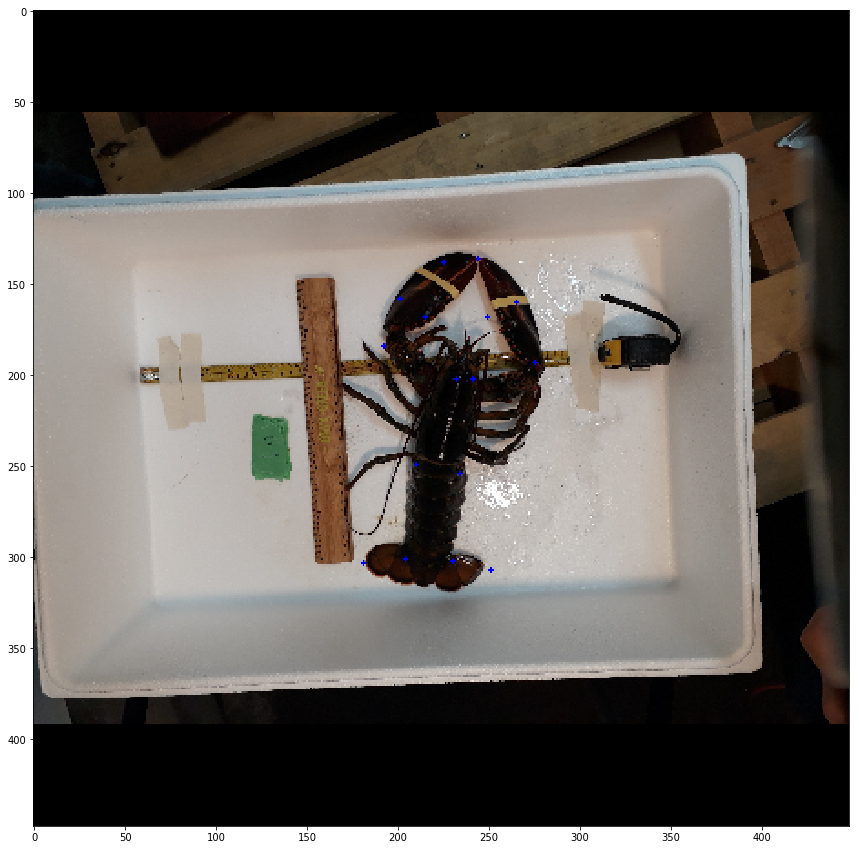

In [57]:
idx = 60
with open('landmarks_localization_vgg16_attention_wing_loss_tangier0.hd5','rb') as f:
    model_weights = pickle.load(f)
    model.set_weights(model_weights)
tuples = []
pred_landmarks = model.predict(np.expand_dims(np.array(test_images[idx]),0))[0]
for i in range(16):
    tuples.append((pred_landmarks[i*2],pred_landmarks[i*2+1]))
for i in range(16):
    img = cv2.circle(test_images[idx],(int(tuples[i][0]),int(tuples[i][1])), 1, (0,0,255), -1)
pil_im = Image.fromarray(img)
plt.figure(figsize=(15,15))
plt.imshow(pil_im)

NameError: name 'history' is not defined

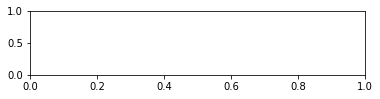

In [8]:
plt.subplot(3,1,1)
plt.plot(history.history['loss'])
plt.xlabel('epochs')
plt.ylabel('Total Loss')
plt.show()
plt.subplot(3,1,2)
plt.plot(history.history['localization_output_iou_metric'])
plt.xlabel('epochs')
plt.ylabel('IoU Metric')
plt.show()
plt.subplot(3,1,3)
plt.plot(history.history['classification_output_loss'])
plt.xlabel('epochs')
plt.ylabel('Cross Entropy Loss')
plt.show()

In [18]:
from sklearn import preprocessing
import numpy
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('classes.npy')

In [22]:
idx = np.random.randint(low=0,high=np.array(test_images).shape[0])
bb,classify = model.predict(np.expand_dims(np.array(test_images)[idx],0))
[[xmin,ymin,xmax,ymax]]= bb
img = cv2.rectangle(np.array(test_images)[idx], (xmin,ymin), (xmax,ymax), (0,255,0), 4)
pil_im = Image.fromarray(img)
a = np.argmax(classify,axis=1)[0]
label = le.inverse_transform(np.argmax(classify,axis=1))
#print(label[0])
#y = ymin - 15 if ymin - 15 > 15 else ymin + 15
plt.title("Predicted: "+label[0]+", Actual: "+le.inverse_transform(np.argmax(test_predictions[idx])))
plt.imshow(pil_im)
print(label[0])

/home/parmeet/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


IndexError: list index out of range

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)!=predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [ ]:
f, axarr = plt.subplots(10)
f.set_figheight(50)
f.set_figwidth(100)
eq_list = np.array(labels_test)==predicted_labels
eq_idx_list = [i for i, x in enumerate(eq_list) if x]
random.shuffle(eq_idx_list)
for idx,i in enumerate(eq_idx_list[0:10]):
    im = images[i]
    imag = normalize_image(im)
    #plt.imshow(imag)
    axarr[idx].imshow(imag)
    axarr[idx].title.set_text('Actual: '+np.array(labels_test)[i]+', Predicted: '+predicted_labels[i])
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predicted_labels,labels=np.unique(labels_))
print(cm)

NameError: name 'labels_test' is not defined

In [ ]:
confusion_matrix(labels_test,predicted_labels)

labels_=list(np.unique(labels_test))
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels_)
ax.set_yticklabels([''] + labels_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [35]:
idx = 101